Final Project: DenseNet Variants on CIFAR-10 and CIFAR-100

1. Overview

This project systematically implements and evaluates DenseNet variants on the CIFAR-10 and CIFAR-100 datasets. We explore the effect of:
	•	Bottleneck Layers (DenseNet-B)
	•	Compression at transition layers (DenseNet-C)
	•	Combinations of growth rates and network depths (e.g., k=12, L=100).

Our aim is to compare the performance (Top-1 and Top-5 accuracy) of each configuration and analyze the trade-offs between accuracy and computational efficiency.

In [1]:
import os

def generate_tree(start_path='.', prefix=''):
    """Recursively generate a tree structure for the directory."""
    entries = sorted(os.listdir(start_path))
    entries_count = len(entries)
    for i, entry in enumerate(entries):
        path = os.path.join(start_path, entry)
        connector = "└── " if i == entries_count - 1 else "├── "
        print(f"{prefix}{connector}{entry}")
        if os.path.isdir(path):
            extension = "    " if i == entries_count - 1 else "│   "
            generate_tree(path, prefix + extension)

# Call the function to generate the tree
generate_tree()

├── .DS_Store
├── .git
│   ├── COMMIT_EDITMSG
│   ├── FETCH_HEAD
│   ├── HEAD
│   ├── ORIG_HEAD
│   ├── branches
│   ├── config
│   ├── description
│   ├── hooks
│   │   ├── applypatch-msg.sample
│   │   ├── commit-msg.sample
│   │   ├── fsmonitor-watchman.sample
│   │   ├── post-update.sample
│   │   ├── pre-applypatch.sample
│   │   ├── pre-commit.sample
│   │   ├── pre-push.sample
│   │   ├── pre-rebase.sample
│   │   ├── pre-receive.sample
│   │   ├── prepare-commit-msg.sample
│   │   └── update.sample
│   ├── index
│   ├── info
│   │   └── exclude
│   ├── logs
│   │   ├── HEAD
│   │   └── refs
│   │       ├── heads
│   │       │   ├── experimental-densenet
│   │       │   └── main
│   │       └── remotes
│   │           └── origin
│   │               ├── HEAD
│   │               ├── experimental-densenet
│   │               └── main
│   ├── objects
│   │   ├── 01
│   │   │   └── 0408a63f12aa4ebaac45bfc56df3af1346bd8d
│   │   ├── 02
│   │   │   └── 791de1a0b6066faf45af1ef985cff3426

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Training labels shape: (50000,)
Test labels shape: (10000,)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 24)        648       
_________________________________________________________________
dense_connect_layer (DenseCo (None, 32, 32, 36)        6624      
_________________________________________________________________
dense_connect_layer_1 (Dense (None, 32, 32, 48)        7248      
_________________________________________________________________
dense_connect_layer_2 (Dense (None, 32, 32, 60)        7872      
_________________________________________________________________
dense_connect_layer_3 (Dense (None, 32, 32, 72)        84

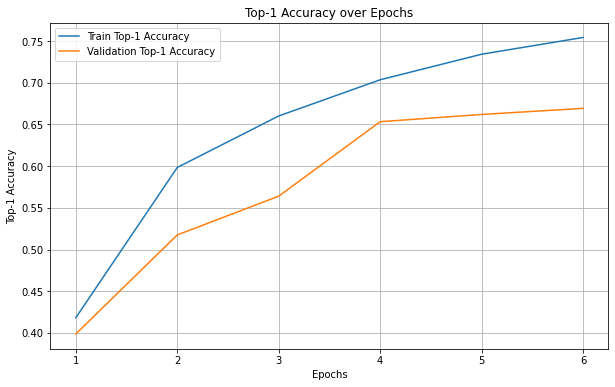

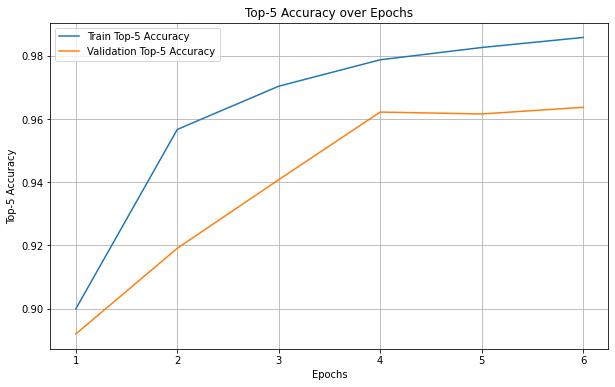

: 

In [1]:
import matplotlib.pyplot as plt
from densenet import create_densenet
from load_data import load_data
from train import Trainer
import tensorflow as tf

# Configuration for this notebook
dataset_name = 'cifar-10'  # or 'cifar-100'
bottleneck = True          # or False
compression = True         # or False

# Load data and model
X_train, y_train, X_test, y_test = load_data(dataset_name)

# Prepare datasets
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

# Adjusted configurations for CIFAR-10 or CIFAR-100
input_size = 32  # Input image size (e.g., 32 for CIFAR)
num_blocks = 3   # Number of dense blocks
depth = 40       # Total depth of the network
num_classes = 10
growth_rate = 12

# Create DenseNet model
model = create_densenet(
    dataset=dataset_name, 
    input_size=input_size,
    depth=depth,
    num_blocks=num_blocks,
    bottleneck=True, 
    compression=True,
    num_classes=num_classes,
    growth_rate=growth_rate
)

model.summary()

initial_lr = 0.1
optimizer = tf.keras.optimizers.SGD(learning_rate=initial_lr, momentum=0.9)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Instantiate Trainer with required arguments
lr_schedule = "cosine"  # or "multistep"
n_epochs = 6  # Total number of epochs
trainer = Trainer(model, optimizer, loss_fn, lr_schedule=lr_schedule, n_epochs=n_epochs, dataset='cifar10')

# To store metrics
train_top1_history = []
val_top1_history = []
train_top5_history = []
val_top5_history = []

for epoch in range(1, n_epochs + 1):
    print(f"--- Epoch {epoch} ---")
    train_loss, train_top1, train_top5 = trainer.train_epoch(train_dataset, epoch)
    val_loss, val_top1, val_top5 = trainer.validate(val_dataset)

    # Append metrics
    train_top1_history.append(train_top1.numpy())
    val_top1_history.append(val_top1.numpy())
    train_top5_history.append(train_top5.numpy())
    val_top5_history.append(val_top5.numpy())

    print(f"Train Loss: {train_loss:.4f}, Top-1 Acc: {train_top1:.4f}, Top-5 Acc: {train_top5:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Top-1 Acc: {val_top1:.4f}, Top-5 Acc: {val_top5:.4f}")

# Plot Top-1 Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_top1_history, label='Train Top-1 Accuracy')
plt.plot(range(1, n_epochs + 1), val_top1_history, label='Validation Top-1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-1 Accuracy')
plt.title('Top-1 Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Top-5 Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_top5_history, label='Train Top-5 Accuracy')
plt.plot(range(1, n_epochs + 1), val_top5_history, label='Validation Top-5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-5 Accuracy')
plt.title('Top-5 Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()